In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dynadojo.systems.lorenz import LorenzSystem
from dynadojo.wrappers import SystemChecker, AlgorithmChecker
from dynadojo.baselines.dnn import DNN, DNNTorch
from dynadojo.baselines.transformer import DecoderTransformer
from dynadojo.utils.lds import plot

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

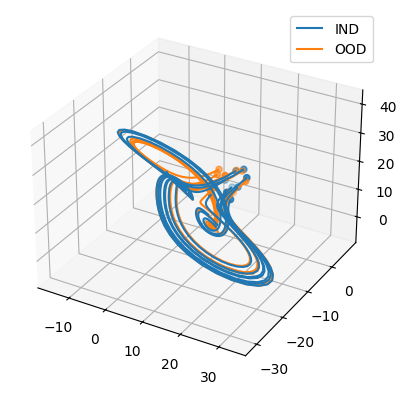

In [6]:
latent_dim = 3
embed_dim = latent_dim
n = 50
test_size = 10
timesteps = 100
system = SystemChecker(LorenzSystem(latent_dim, embed_dim, noise_scale=0, seed=1912,
                                    sigma=10, r=28, a_squared=1/2.0, b=8.0/3.0, 
                                    t_range=(0, 1),
                                    ))
# system = SystemChecker(LDSystem(latent_dim, embed_dim, noise_scale=0, seed=1912))
x0 = system.make_init_conds(n)
y0 = system.make_init_conds(test_size, in_dist=True)
x = system.make_data(x0, timesteps=timesteps)
y = system.make_data(y0, timesteps=timesteps, noisy=False)
plot([x, y], target_dim=min(latent_dim, 3), labels=["IND", "OOD"], max_lines=test_size)

In [13]:
model1 = AlgorithmChecker(
    DNN(embed_dim, timesteps, max_control_cost=0, seed=109, 
    )
)
model2 = AlgorithmChecker(
    DNNTorch(embed_dim, timesteps, max_control_cost=0, seed=109, 
    )
)

model3 = AlgorithmChecker(
    DecoderTransformer(embed_dim, timesteps, max_control_cost=0, seed=109, 
                       model_dim=3, num_heads=3, num_layers=6, dropout=0.1, activation="relu",
    )
)



In [8]:
model1.fit(x, 
        epochs=2000,
        batch_size=50,
        learning_rate=1e-1 ,
        validation_split=0.1,
        patience=3,
        min_delta=0,
        start_early_stop_from_epoch=500,
        verbose=1)


Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 186.7705 - val_loss: 184.3045
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 181.3845 - val_loss: 178.5235
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 175.7892 - val_loss: 172.6535
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 170.1222 - val_loss: 166.7516
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 164.4257 - val_loss: 160.8665
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 158.8092 - val_loss: 155.0010
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 153.2113 - val_loss: 149.1338
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 147.5853 - val_loss: 143.2548
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 141.9093 - val_loss: 137.2965
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 136.1215 - val_loss: 131.2227
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 130.2008 - val_loss: 125.0578
Epoch 12/2000
1/1 ━━━

In [24]:
model2.fit(x, 
        epochs=2000,
        batch_size=50,
        learning_rate=1e-3, 
        validation_split=0.1,
        patience=3,
        min_delta=0,
        start_early_stop_from_epoch=500,
        verbose=1)


Training on 0.9 of the data, validating on the rest
Early stopping from epoch 500 with patience 3 and min_delta 0
Epoch [1/2000], Loss: 67.1501, Val Loss: 66.6789, , took 1.68s
Epoch [101/2000], Loss: 59.6801, Val Loss: 59.6362, , took 207.89s


KeyboardInterrupt: 

In [ ]:
model3.fit(x, 
        epochs=2000,
        batch_size=50,
        learning_rate=1e-1 ,
        validation_split=0.1,
        patience=3,
        min_delta=0,
        start_early_stop_from_epoch=500,
        verbose=1)


y_err=9.114035740335316


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

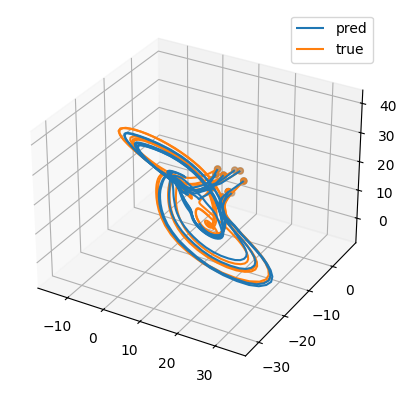

In [9]:
y_pred = model1.predict(y0, timesteps)
y_err = system.calc_error(y, y_pred)
print(f"{y_err=}")
plot([y_pred, y], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

In [ ]:
y_pred = model2.predict(y0, timesteps)
y_err = system.calc_error(y, y_pred)
y - y_pred
print(f"{y_err=}")
plot([y_pred, y], target_dim=min(3, latent_dim), labels=["pred", "true"], max_lines=15)

In [10]:
import torch

loss = torch.nn.MSELoss()
input = torch.from_numpy(y.reshape(-1)).float()
output = torch.from_numpy(y_pred.reshape(-1)).float()
loss(input, output)


tensor(27.3421)